# Mini neural net training
Authors: Alfredo Canziani, Philipp Schmitt  
Date: Tue 24 Feb 2020

In [331]:
import torch
from torch import nn, optim
from IPython import display
from PIL import Image, ImageFont, ImageDraw
from matplotlib.pyplot import imshow, axis, figure, subplot, pause
import numpy
import random
import math

%matplotlib inline

In [332]:
# static random seed
torch.manual_seed(0)

In [376]:
# Input definition
class input_settings:
    batch_size = 1
    channels = 1
    height = 8
    width = 8

dummy_X = torch.randn(  # batch of inputs x
    input_settings.batch_size,
    input_settings.channels,
    input_settings.height,
    input_settings.width,
)

In [396]:
# Network architecture
class model_settings:
    conv_channels = 4
    kernel = 3
    pooling_kernel = 3
    flattened = 16
    output_size = 1
    
model = nn.Sequential(
    nn.Conv2d(
        in_channels=input_settings.channels,
        out_channels=model_settings.conv_channels,
        kernel_size=model_settings.kernel,
        bias=True,
    ),
    nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=model_settings.pooling_kernel,
        stride=model_settings.pooling_kernel,
    ),  # we have 4 x 2x2
    nn.Flatten(),  # gives 16
    nn.Linear(
        in_features=model_settings.flattened,
        out_features=model_settings.output_size,
        bias=True,
    ),
)

In [378]:
# Inference
with torch.no_grad():
    print(model(dummy_X).size())

torch.Size([1, 1])


In [379]:
# Print the model architecture
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [337]:
# Get weights and biases
def get_weights():
    print(
        model[0],
        model[0].weight,
        model[0].bias,
        sep='\n',
    )
    print(
        model[4],
        model[4].weight,
        model[4].bias,
        sep='\n',
    )
    # Maybe add some saving routines

In [338]:
font = ImageFont.truetype('Verdana', 8)  # let's keep it to Verdana 8pt
data_set_settings = dict(
    D=dict(
        x_min = -1,
        x_max = 2,
        y_min = -3,
        y_max = -1,
    ),
    C=dict(
        x_min = 0,
        x_max = 3,
        y_min = -4,
        y_max = -2,
    )
)

In [364]:
def generate_data(visualise=False, target=None):
    image = Image.new('L', (input_settings.height, input_settings.width))
    draw = ImageDraw.Draw(image)
    draw.fontmode = '1'
    if not target:
        character = random.choice(('C', 'D'))
    else:
        character = target

    x = random.randint(
        data_set_settings[character]['x_min'],
        data_set_settings[character]['x_max'],
    )
    y = random.randint(
        data_set_settings[character]['y_min'],
        data_set_settings[character]['y_max'],
    )

    draw.text((x, y), character, (255,), font=font)
    data = numpy.array(image, dtype=numpy.float32) / 255
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
    
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))

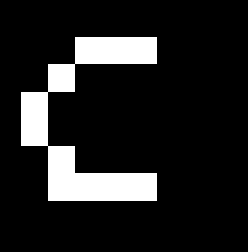

In [365]:
generate_data(visualise=True)

In [394]:
# letter samples
samples = [
    [
        [0,1,1,1],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
        [0,1,1,1]
    ],
    [
        [1,1,1],
        [1,0,0],
        [1,0,0],
        [1,1,1]
    ],
    [
        [1,1,1,0],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,0,0,1],
        [1,1,1,0]
    ],
    [
        [1,1,0],
        [1,0,1],
        [1,0,1],
        [1,1,0]
    ]
]

sample_meta = [
    [6,4,'C'],
	[4,3,'C'],
	[6,4,'D'],
	[4,3,'D']
]

(tensor([[[0., 1., 1., 1., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))

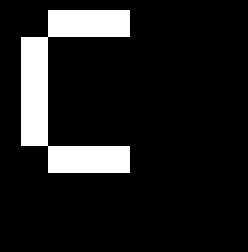

In [395]:
# updated gen. function to match teensy implementation
def generate_data(visualise=False, target=None):
    data = numpy.zeros(shape=(8,8), dtype=numpy.float32)
    
    sample = random.randint(0,len(samples)-1)
    character = sample_meta[sample][2];
    
    x = random.randint(
        0,
        input_settings.width-sample_meta[sample][1]
    )
    y = random.randint(
        0,
        input_settings.height-sample_meta[sample][0]
    )
    
    data[y:y+sample_meta[sample][0],x:x+sample_meta[sample][1]] = samples[sample]
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
        
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)
        
generate_data(visualise=True)

In [343]:
# Generate a C, D batch
def get_batch(visualise=False):
    Cx, Cy = generate_data(target='C', visualise=visualise)
    Dx, Dy = generate_data(target='D', visualise=visualise)
    x = torch.stack((Cx, Dx))
    y = torch.stack((Cy, Dy))
    return x, y

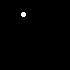

In [344]:
from PIL import Image, ImageDraw
from numpy import interp
from math import cos, sin, radians, pi


def draw_weight(value, size=20):
    rad = interp(value,[-.75,.75],[pi,0])
    im = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(im)
    x, y, r = (
        size/2 + size/3 * cos(rad), 
        size/2 - size/3 * sin(rad),
        4)
    draw.ellipse((x-r/2, y-r/2, x+r/2, y+r/2), fill=(255, 255, 255), outline=None)

    return im

draw_weight(-.25, 70)

In [345]:
# draw weights

def draw_weights(layer, size=20):
    weights = layer.weight.data.clone().numpy()

    n_weights = len(weights[0])
    im = Image.new('RGB', ((size+1)*n_weights, size), (255, 255, 255))

    for i in range(n_weights):
        weight = draw_weight(weights[0][i], size=size)
        im.paste(weight,((size+1)*i,0))

    return im

draw_weights(model[4], size=30)

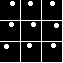

In [346]:
# draw a filter
def draw_filter(filter):
    matrix = Image.new('RGB', (63, 63), (255, 255, 255))
    data = filter.view(3, 3).numpy()
    # go over filter
    # rows
    for x in range(0, data.shape[0]):
        # cols
        for y in range(0, data.shape[1]):
            vis = draw_weight(data[y,x])
            matrix.paste(vis,(x*21,y*21))
    return matrix

filters = model[0].weight.data
draw_filter(filters[0])

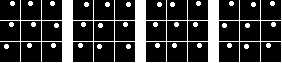

In [347]:
# draw all filters
def draw_filters(layer):
    matrix = Image.new('RGB', (282, 63), (255, 255, 255))
    filters = layer.weight.data.clone()
    for i, filter in enumerate(filters):
        vis = draw_filter(filter)
        matrix.paste(vis, (i*(63+10),0))
    return matrix


draw_filters(model[0])

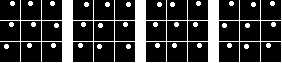

In [348]:
draw_filters(model[0])

In [349]:
#model[0].weight.data.fill_(0)
#model[4].weight.data.fill_(0)

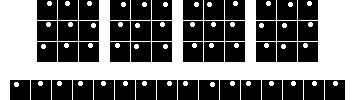

In [350]:
# draw all the weights in the net
def draw_net():
    im = Image.new('RGB', (356, 100), (255, 255, 255))
    im.paste(draw_filters(model[0]), (37,0))
    im.paste(draw_weights(model[4]), (10,80))

    return im

draw_net()

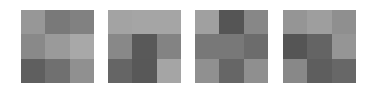

In [351]:
# Visualize weights
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    # visualize
    for i in range(0, len(filters)):
        data = filters[i].view(3, 3)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
        
visualize_filters(model[0])

---
# Training

In [397]:
# Set up network training
nb_epochs = 10_000
lr = 1e-3
optimiser = optim.SGD(params=model.parameters(), lr=lr)
#loss = nn.BCEWithLogitsLoss()
loss = nn.BCEWithLogitsLoss()

In [398]:
optimiser

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [401]:
# Training
for epoch in range(nb_epochs):
    # Training steps
    X, Y = generate_data()
    logits = model(X.unsqueeze(0))  # feed-forward
    
    # not sure if I'm doing this right ...
    logits = logits.squeeze(-2)
    Y = Y.unsqueeze(0)

    J = loss(logits, Y)  # computes the loss
    model.zero_grad()  # cleans up previous gradients
    J.backward()
    optimiser.step()
    
    # Accuracy computation and display
    score, predicted = torch.max(logits, 0)
    acc = (Y == (logits > 0)).sum().float() / len(Y)
    
    if(epoch % 100 == 0):
        display.clear_output(wait=True)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, J.item(), acc))
        
        continue
        
        print(model[0].weight.data)
        
        figure(figsize=(10, 20))
        #visualize_filters(model[0])
        im = draw_net()
        imshow(numpy.asarray(im), aspect='equal', interpolation='nearest')
        
        # im.save('%s.png' % epoch)
        
        #draw_filters(model[0]).save('%i.png' % epoch)
        axis('off');
        pause(0.1)

[EPOCH]: 9900, [LOSS]: 0.204992, [ACCURACY]: 1.000


D


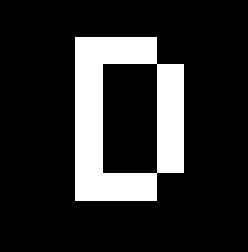

In [431]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=True)[0].unsqueeze_(0)) > 0 else 'D')

In [61]:
# register hook to get activation after conv layer out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

backward = {}
def get_backward(name):
    def hook(model, input, output):
        backward[name] = {}
        backward[name]['input'] = input
        backward[name]['output'] = output
    return hook

model[0].register_forward_hook(get_activation('act'))
model[1].register_forward_hook(get_activation('relu'))
model[2].register_forward_hook(get_activation('pool'))
model[3].register_forward_hook(get_activation('flatten'))

model[0].register_backward_hook(get_backward('conv'))
model[1].register_backward_hook(get_backward('relu'))
model[2].register_backward_hook(get_backward('pool'))
model[3].register_backward_hook(get_backward('flatten'))
model[4].register_backward_hook(get_backward('lin'))

C


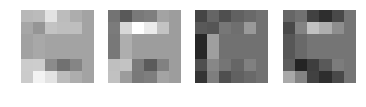

In [62]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=False)[0].unsqueeze_(0)) > 0 else 'D')
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');

---
# A printout of sample data, activations, outputs to troubleshoot Teensy implementation

In [104]:
print("CONV WEIGHTS")
print(model[0].weight.clone().detach().squeeze(1).numpy())
print('CONV BIAS')
print(model[0].bias.clone().detach().numpy())

print('\nLIN WEIGHTS')
print(model[4].weight.clone().detach().numpy())
print('LIN BIAS')
print(model[4].bias.clone().detach().numpy())

CONV WEIGHTS
[[[ 0.2017441   0.00308158  0.04606714]
  [ 0.07480983  0.11689769  0.30476084]
  [-0.24218692 -0.14427844  0.19337441]]

 [[ 0.30300942  0.30281624  0.32107574]
  [ 0.04421493 -0.2898609  -0.02634343]
  [-0.21836622 -0.30158904  0.25087616]]

 [[ 0.30892864 -0.33250934  0.06331794]
  [-0.06391373 -0.05740379 -0.15258563]
  [ 0.10691884 -0.1978942   0.11555099]]

 [[ 0.18961638  0.25415832  0.14558695]
  [-0.33572823 -0.22541218  0.14864472]
  [ 0.05087484 -0.26549476 -0.21621124]]]
CONV BIAS
[ 0.28327325  0.23270558 -0.10685033 -0.07848678]

LIN WEIGHTS
[[-2.2068898e-01 -2.1241444e-04 -1.3680935e-01 -1.7643958e-01
   1.5825884e-02  1.4667754e-01 -6.2232032e-02  1.5228274e-01
  -1.4018767e-01  2.4638823e-01  1.6870129e-01 -2.3665445e-01
  -1.4726459e-02  1.2934357e-01  1.0478461e-01  1.1715993e-01]]
LIN BIAS
[0.15213825]


(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))


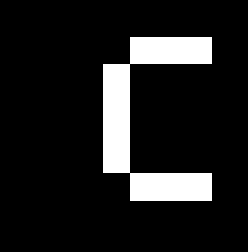

In [145]:
dat = generate_data(visualise=True)
print(dat)

C
tensor([[ 0.2833,  0.4766,  0.4438,  0.4627,  0.7797,  0.4750],
        [ 0.2833,  0.7814,  0.3020,  0.1650,  0.5342,  0.4881],
        [ 0.2833,  0.8275,  0.2590,  0.3176,  0.2833,  0.2833],
        [ 0.2833,  0.8275,  0.2590,  0.3176,  0.2833,  0.2833],
        [ 0.2833,  0.6341,  0.5966,  0.6089,  0.0902, -0.1032],
        [ 0.2833,  0.3293,  0.5911,  0.9067,  0.7797,  0.4750]])
tensor([[ 0.2327,  0.4836, -0.0952, -0.3019, -0.0393, -0.0129],
        [ 0.2327,  0.4572, -0.0377,  0.6824,  1.1596,  0.8385],
        [ 0.2327,  0.7783, -0.0559,  0.3616,  0.2327,  0.2327],
        [ 0.2327,  0.7783, -0.0559,  0.3616,  0.2327,  0.2327],
        [ 0.2327,  0.5274,  0.4965,  0.5292, -0.0364, -0.2872],
        [ 0.2327,  0.5538,  0.5092,  0.2195, -0.0393, -0.0129]])
tensor([[-0.1069,  0.0087, -0.4573, -0.2099, -0.3808, -0.2282],
        [-0.1069, -0.1439, -0.2988, -0.3330, -0.0671, -0.1304],
        [-0.1069, -0.0806, -0.6947,  0.2451, -0.1069, -0.1069],
        [-0.1069, -0.0806, -0.6947, 

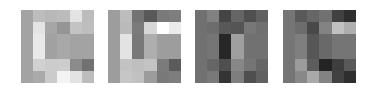

In [147]:
with torch.no_grad():
    #dat = generate_data(visualise=False)
    x = dat[0].clone().unsqueeze_(0)
    y = model(x)
    print('C' if y > 0 else 'D')
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        print(act)
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
    
    print("\n")
    
    print("relu:")
    print(activation["relu"])
    print("\n")
    
    print("pool:")
    print(activation["pool"])
    print("\n")
    
    print("flatten:")
    print(activation["flatten"])
    print("\n")
    
    print(y.item())

In [167]:
# backward pass
X, Y = dat
logits = model(X.clone().unsqueeze_(0))  # feed-forward

# not sure if I'm doing this right ...
logits = logits.squeeze(-2)
Y = Y.unsqueeze(0)

J = loss(logits, Y)  # computes the loss

print('out   ', logits.item())
print('target', Y.item())
print('loss  ', J.item())

model.zero_grad()  # cleans up previous gradients

J.backward()

out    0.015991762280464172
target 1.0
loss   0.6851832270622253


---
# Framework-less backprop

In [168]:
w_old = {
    'lin': model[4].weight.clone().detach(),
    'lin_bias': model[4].bias.clone().detach(),
    'conv': model[0].weight.clone().detach(),
    'conv_bias': model[0].bias.clone().detach(),
}

In [169]:
def sigmoid(x):
    # e^x => math.e ** 2
    return 1 / (1 + math.e ** -x)

In [171]:
# BCEwithLogits Loss, formula from
# https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/Loss.cpp

y = logits

max_val = max(0, -y)
l = (1-Y) * y + max_val + math.log((math.e ** -max_val) + math.e ** (-y-max_val))

# Derivative of BCEwithLogits Loss
# grad_input = (input.sigmoid() - target).mul_(grad);
dl = (sigmoid(y) - Y) * 1

print("L: ", l.item())
print("dL:", dl.item())
print('\nGOAL\n', J.item(), "\n", backward["lin"]["input"][0].item())

L:  0.6851832270622253
dL: -0.4960021376609802

GOAL
 0.6851832270622253 
 -0.4960021376609802


In [172]:
# backward pass, linear layer
dx = model[4].weight * dl
dw = activation['flatten'] * dl
db = dl

print('\ndW\n',dw)
print(' GOAL\n', model[4].weight.grad)
print(' DIFF', numpy.sum(a=(dw.detach().numpy() - model[4].weight.grad.detach().numpy())))

print('\n\ndX\n',dx)
print(' GOAL\n', backward["lin"]["input"][1])
print(' DIFF', numpy.sum(a=(dx.detach().numpy() - numpy.array(backward["lin"]["input"][1]))))

print('\n\ndB\n',db)
print(' GOAL\n', model[4].bias.grad)
print(' DIFF', numpy.sum(a=(db.detach().numpy() - model[4].bias.grad.detach().numpy())))


dW
 tensor([[-0.4104, -0.3868, -0.4104, -0.4497, -0.3860, -0.5752, -0.3860, -0.2625,
         -0.0043, -0.1216, -0.0000, -0.1216, -0.0000, -0.2534, -0.1609, -0.0170]],
       grad_fn=<MulBackward0>)
 GOAL
 tensor([[-0.4104, -0.3868, -0.4104, -0.4497, -0.3860, -0.5752, -0.3860, -0.2625,
         -0.0043, -0.1216,  0.0000, -0.1216,  0.0000, -0.2534, -0.1609, -0.0170]])
 DIFF 0.0


dX
 tensor([[ 1.0946e-01,  1.0536e-04,  6.7858e-02,  8.7514e-02, -7.8497e-03,
         -7.2752e-02,  3.0867e-02, -7.5533e-02,  6.9533e-02, -1.2221e-01,
         -8.3676e-02,  1.1738e-01,  7.3044e-03, -6.4155e-02, -5.1973e-02,
         -5.8112e-02]], grad_fn=<MulBackward0>)
 GOAL
 tensor([[ 1.0946e-01,  1.0536e-04,  6.7858e-02,  8.7514e-02, -7.8497e-03,
         -7.2752e-02,  3.0867e-02, -7.5533e-02,  6.9533e-02, -1.2221e-01,
         -8.3676e-02,  1.1738e-01,  7.3044e-03, -6.4155e-02, -5.1973e-02,
         -5.8112e-02]])
 DIFF 0.0


dB
 tensor([-0.4960], grad_fn=<MulBackward0>)
 GOAL
 tensor([-0.4960])
 DIFF 0

In [197]:
# backward pass, flatten
out = dx.reshape((4,2,2))
goal = backward['pool']['output']

print(out)
print('\nGOAL\n', goal)

tensor([[[ 1.0946e-01,  1.0536e-04],
         [ 6.7858e-02,  8.7514e-02]],

        [[-7.8497e-03, -7.2752e-02],
         [ 3.0867e-02, -7.5533e-02]],

        [[ 6.9533e-02, -1.2221e-01],
         [-8.3676e-02,  1.1738e-01]],

        [[ 7.3044e-03, -6.4155e-02],
         [-5.1973e-02, -5.8112e-02]]], grad_fn=<ViewBackward>)

GOAL
 (tensor([[[[ 1.0946e-01,  1.0536e-04],
          [ 6.7858e-02,  8.7514e-02]],

         [[-7.8497e-03, -7.2752e-02],
          [ 3.0867e-02, -7.5533e-02]],

         [[ 6.9533e-02, -1.2221e-01],
          [-8.3676e-02,  1.1738e-01]],

         [[ 7.3044e-03, -6.4155e-02],
          [-5.1973e-02, -5.8112e-02]]]]),)


In [220]:
# backward pass, maxpool2d
# not implemented here...
# the gradient gets assigned to the item that was max() during forward pass

print('\nGOAL\n', backward['pool']['input'])


GOAL
 (tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0536e-04,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  1.0946e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  6.7858e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.7514e-02,  0.0000e+00,
            0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -7.2752e-02,
            0.0000e+00],
          [ 0.0000e+00, -7.8497e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00],
          [ 0.0000e+00,  3.0867e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
     

In [238]:
# derivative of relu
# see here: https://towardsdatascience.com/back-propagation-simplified-218430e21ad0
# d = numpy.array(backward['pool']['input'][0][0][0], copy = True)
# d[activation['relu'][0][0] < 0] = 0.

relu_grad = backward['pool']['input'][0][0].clone().detach()

for f in range(0,4):
    for y in range(0,6):
        for x in range(0,6):
            if(activation['act'][0][f][y][x] <= 0):
                relu_grad[f][y][x] = 0
                
print(relu_grad)
print('\nGOAL\n', backward['relu']['input'][0][0])

print('\nDIFF', (backward['relu']['input'][0][0] - relu_grad).sum().item())

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0536e-04,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  1.0946e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  6.7858e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.7514e-02,  0.0000e+00,
           0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -7.2752e-02,
           0.0000e+00],
         [ 0.0000e+00, -7.8497e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  3.0867e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
        

---
## Do an optimiser step

In [253]:
optimiser.step()

In [254]:
w_new = {
    'lin': model[4].weight.clone().detach(),
    'lin_bias': model[4].bias.clone().detach(),
    'conv': model[0].weight.clone().detach(),
    'conv_bias': model[0].bias.clone().detach(),
}

---
## Update weights

In [255]:
# lin layer, weight update
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
weight_update = w_old['lin'].clone()
weight_update -= lr * dw.clone().detach()

# goal
goal = w_new['lin'][0].numpy()
print(weight_update)
print('\nGOAL\n', goal)
print('\nDIFF:', numpy.sum(a=(goal - weight_update[0].numpy())))

tensor([[-2.2065e-01, -1.7374e-04, -1.3677e-01, -1.7639e-01,  1.5864e-02,
          1.4674e-01, -6.2193e-02,  1.5231e-01, -1.4019e-01,  2.4640e-01,
          1.6870e-01, -2.3664e-01, -1.4726e-02,  1.2937e-01,  1.0480e-01,
          1.1716e-01]])

GOAL
 [-2.2064795e-01 -1.7373908e-04 -1.3676831e-01 -1.7639461e-01
  1.5864490e-02  1.4673506e-01 -6.2193427e-02  1.5230900e-01
 -1.4018723e-01  2.4640039e-01  1.6870129e-01 -2.3664229e-01
 -1.4726459e-02  1.2936892e-01  1.0480069e-01  1.1716164e-01]

DIFF: 0.0


In [256]:
# lin layer, bias update
new_bias = w_old['lin_bias'].clone() - db * lr

print('CALC:', new_bias.item())
print('GOAL:', model[4].bias.item())
print('DIFF:', (model[4].bias.item()-new_bias).item())

CALC: 0.15218785405158997
GOAL: 0.15218785405158997
DIFF: 0.0


---
#### conv weights

In [279]:
# backward pass, conv

# only doing it here, after optimiser.step() so that model[0].weight.grad has a gradient for comparison

# incoming gradient
g = backward['relu']['input'][0][0]

# gradient var
conv_grad = torch.zeros((4,3,3))

# filters
for f in range(0,4):
    for fy in range(0,3):
        for fx in range(0,3):
            # slide gradient over input X to get dF
            for y in range(0,6):
                for x in range(0,6):
                    conv_grad[f][fy][fx] += g[f][y][x] * dat[0][0][y+fy][x+fx]

goal = model[0].weight.grad.clone().squeeze(1)

print(conv_grad.numpy())
print('\nGOAL\n', goal)
print('DIFF', (conv_grad - goal).sum().item())

[[[ 8.75144079e-02  0.00000000e+00  1.77319944e-01]
  [ 1.05358013e-04  8.76197666e-02  2.64939696e-01]
  [ 0.00000000e+00  0.00000000e+00  1.77319944e-01]]

 [[-1.48284942e-01 -7.27523714e-02 -4.97348234e-02]
  [-7.55325705e-02  0.00000000e+00  2.30175480e-02]
  [ 0.00000000e+00 -7.55325705e-02 -5.25150225e-02]]

 [[-4.82797623e-03  0.00000000e+00  0.00000000e+00]
  [-4.82797623e-03  0.00000000e+00  0.00000000e+00]
  [-4.82797623e-03  0.00000000e+00  6.95333853e-02]]

 [[-1.22266263e-01 -1.16128072e-01 -6.41546845e-02]
  [ 0.00000000e+00 -5.81115782e-02 -1.10084966e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]]

GOAL
 tensor([[[ 8.7514e-02,  0.0000e+00,  1.7732e-01],
         [ 1.0536e-04,  8.7620e-02,  2.6494e-01],
         [ 0.0000e+00,  0.0000e+00,  1.7732e-01]],

        [[-1.4828e-01, -7.2752e-02, -4.9735e-02],
         [-7.5533e-02,  0.0000e+00,  2.3018e-02],
         [ 0.0000e+00, -7.5533e-02, -5.2515e-02]],

        [[-4.8280e-03,  0.0000e+00,  0.0000e+00],
       

In [266]:
new_weights = w_old['conv'].clone().squeeze(1)
new_weights -= lr * conv_grad
goal = w_new['conv'].clone().squeeze(1)

print(new_weights)
print('\nGOAL:', goal)
print('DIFF:', (goal - new_weights).sum().item())

tensor([[[ 0.2017,  0.0031,  0.0460],
         [ 0.0748,  0.1169,  0.3047],
         [-0.2422, -0.1443,  0.1934]],

        [[ 0.3030,  0.3028,  0.3211],
         [ 0.0442, -0.2899, -0.0263],
         [-0.2184, -0.3016,  0.2509]],

        [[ 0.3089, -0.3325,  0.0633],
         [-0.0639, -0.0574, -0.1526],
         [ 0.1069, -0.1979,  0.1155]],

        [[ 0.1896,  0.2542,  0.1456],
         [-0.3357, -0.2254,  0.1487],
         [ 0.0509, -0.2655, -0.2162]]])

GOAL: tensor([[[ 0.2017,  0.0031,  0.0460],
         [ 0.0748,  0.1169,  0.3047],
         [-0.2422, -0.1443,  0.1934]],

        [[ 0.3030,  0.3028,  0.3211],
         [ 0.0442, -0.2899, -0.0263],
         [-0.2184, -0.3016,  0.2509]],

        [[ 0.3089, -0.3325,  0.0633],
         [-0.0639, -0.0574, -0.1526],
         [ 0.1069, -0.1979,  0.1155]],

        [[ 0.1896,  0.2542,  0.1456],
         [-0.3357, -0.2254,  0.1487],
         [ 0.0509, -0.2655, -0.2162]]])
DIFF: 0.0


In [267]:
# conv layer, bias update
# -> sum of filter gradient is dB
# https://stackoverflow.com/questions/3775032/how-to-update-the-bias-in-neural-network-backpropagation
# https://datascience.stackexchange.com/questions/25081/how-to-update-bias-in-cnn

# biases before weight update
biases = w_old['conv_bias'].clone()

for i in range(len(biases)):
    biases[i] -= g[i].sum() * lr

goal = model[0].bias.clone().detach()

print(biases)
print('GOAL:', goal)
print('DIFF:', (goal - biases).sum().item())

tensor([ 0.2832,  0.2327, -0.1069, -0.0785])
GOAL: tensor([ 0.2832,  0.2327, -0.1069, -0.0785])
DIFF: 0.0
